In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import os
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd

In [3]:
# Load CSV
train_df = pd.read_csv(r"/kaggle/input/coral-health/coral_health_counts_train.csv")
val_df = pd.read_csv(r"/kaggle/input/coral-health/coral_health_counts_all_vaild.csv")
test_df = pd.read_csv(r"/kaggle/input/coral-health/coral_health_counts_test.csv")
# Rename columns for easier use
print(val_df.head())

train_df.columns = ["filename", "healthy", "bleached", "dead"]
val_df.columns = ["filename", "healthy", "bleached", "dead"]
test_df.columns = ["filename", "healthy", "bleached", "dead"]

# Convert any value > 0 to 1 (multi-label binary classification)
train_df[["healthy", "bleached", "dead"]] = train_df[["healthy", "bleached", "dead"]].map(lambda x: 1 if x > 0 else 0)
val_df[["healthy", "bleached", "dead"]] = val_df[["healthy", "bleached", "dead"]].map(lambda x: 1 if x > 0 else 0)
test_df[["healthy", "bleached", "dead"]] = test_df[["healthy", "bleached", "dead"]].map(lambda x: 1 if x > 0 else 0)

# Save cleaned CSV
train_df.to_csv("train_labels.csv", index=False)
val_df.to_csv("valid_labels.csv", index=False)
test_df.to_csv("test_labels.csv", index=False)

print(val_df.head())

                                          Image Name  Healthy Coral  \
0  100_png_jpg.rf.4e8af62b00b8c6c52dd840e660d7306...              0   
1  104_png_jpg.rf.6ba571835d00912c88ff23760f48fae...              3   
2  104_png_jpg.rf.dc5840119152b25e12eb5fef105bb5a...              3   
3  109_png_jpg.rf.ed0d5a7d101d1912871ee05a3a1448f...              0   
4  110_png_jpg.rf.abad06977932322dcdec9c4506f4dba...              0   

   Bleached Coral  Dead Coral  
0               0           2  
1               0           0  
2               0           0  
3               0           1  
4               0           1  
                                            filename  healthy  bleached  dead
0  100_png_jpg.rf.4e8af62b00b8c6c52dd840e660d7306...        0         0     1
1  104_png_jpg.rf.6ba571835d00912c88ff23760f48fae...        1         0     0
2  104_png_jpg.rf.dc5840119152b25e12eb5fef105bb5a...        1         0     0
3  109_png_jpg.rf.ed0d5a7d101d1912871ee05a3a1448f...        0        

In [4]:
dataset_path = "/kaggle/input/coral-health/marjan-segmentaion.v15i.voc"
print("Dataset contents:", os.listdir(dataset_path))

# Load Cleaned Data
train_df = pd.read_csv("train_labels.csv")
val_df = pd.read_csv("valid_labels.csv")
test_df = pd.read_csv("test_labels.csv")

# Define dataset paths (update if needed)
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

# Image dimensions & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Dataset contents: ['README.dataset.txt', 'README.roboflow.txt', 'valid', 'test', 'train']


In [6]:
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8, 1.2],  # Adjust lighting
    zoom_range=0.3,  # Stronger zoom
    horizontal_flip=True,
    vertical_flip=True,  # Add vertical flips (useful for corals)
    fill_mode="nearest"
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="filename",
    y_col=["healthy", "bleached", "dead"],  # Multi-label columns
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw"  # Multi-label classification
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=valid_dir,
    x_col="filename",
    y_col=["healthy", "bleached", "dead"],
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw"
)

test_generator = test_datagen.flow_from_dataframe(
   dataframe=test_df,
    directory=test_dir,
    x_col="filename",
    y_col=["healthy", "bleached", "dead"],
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    shuffle=False 
)

Found 4956 validated image filenames.
Found 353 validated image filenames.
Found 354 validated image filenames.


In [23]:
# Load ResNet50 with pre-trained weights
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Build Model
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(3, activation="sigmoid")(x)  # 3 classes (healthy, bleached, dead)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss="binary_crossentropy", 
              metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")])


In [28]:
print(model.metrics_names)  # Will show ['loss', 'binary_accuracy']

['loss', 'compile_metrics']


In [30]:
# Callbacks
checkpoint = ModelCheckpoint("best_model.keras",
                             monitor="val_binary_accuracy",
                             save_best_only=True,
                             mode="max", verbose=1)
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=5,
                               mode="min",
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_binary_accuracy", factor=0.2,
                              patience=5,
                              min_lr=1e-6)

callbacks=[early_stopping, reduce_lr, checkpoint]

In [31]:
class_names = ["healthy", "bleached", "dead"]
class_counts = np.array([1605, 1626, 2199])  # Your dataset stats
class_weights = compute_class_weight("balanced", classes=np.unique(class_names), y=class_names)
class_weights_dict = dict(enumerate(class_weights))

# Train Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - binary_accuracy: 0.5047 - loss: 0.7139
Epoch 1: val_binary_accuracy improved from -inf to 0.54674, saving model to best_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 90s 556ms/step - binary_accuracy: 0.5048 - loss: 0.7138 - val_binary_accuracy: 0.5467 - val_loss: 0.6825 - learning_rate: 1.0000e-05
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - binary_accuracy: 0.5689 - loss: 0.6773
Epoch 2: val_binary_accuracy improved from 0.54674 to 0.62890, saving model to best_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 78s 481ms/step - binary_accuracy: 0.5690 - loss: 0.6773 - val_binary_accuracy: 0.6289 - val_loss: 0.6736 - learning_rate: 1.0000e-05
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - binary_accuracy: 0.6147 - loss: 0.6605
Epoch 3: val_binary_accuracy improved from 0.62890 to 0.65156, saving model to best_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 79s 489ms/step - binary_accuracy: 0.6147 - loss: 0.6605 - val_binary_accuracy

In [ ]:
# # Fine-Tuning: Unfreeze deeper layers and train again
# for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
#     layer.trainable = True

# model.compile(optimizer=Adam(learning_rate=1e-6), 
#               loss="binary_crossentropy", 
#               metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")])

# history_finetune = model.fit(
#     train_generator,
#     validation_data=valid_generator,
#     epochs=20,
#     callbacks=[early_stopping, reduce_lr]
# )

# # Load the best model (optional, but recommended)
# from tensorflow.keras.models import load_model
# best_model = load_model("best_model.keras")


In [36]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")



/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step - binary_accuracy: 0.7193 - loss: 0.5777
Test Accuracy: 0.7185


In [ ]:
# # Save Model
# model.save("final_coral_classifier_resnet50.h5")

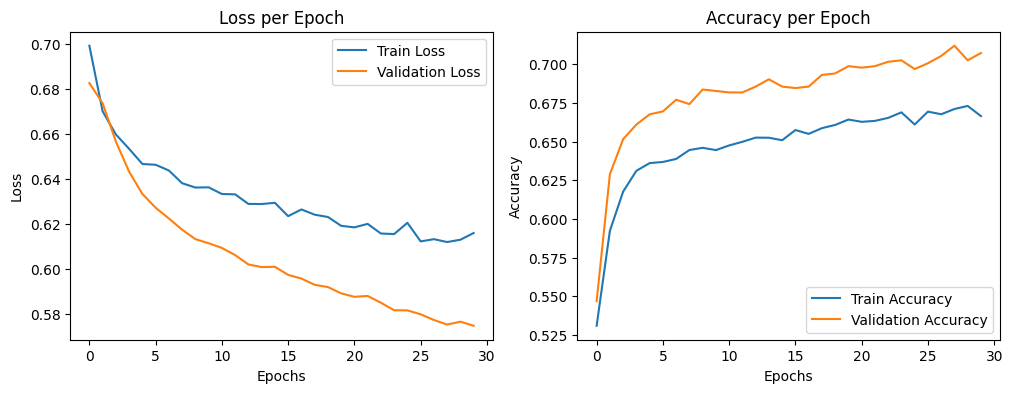

In [35]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss per Epoch")

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_binary_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy per Epoch")

    plt.show()

plot_training_results(history)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step


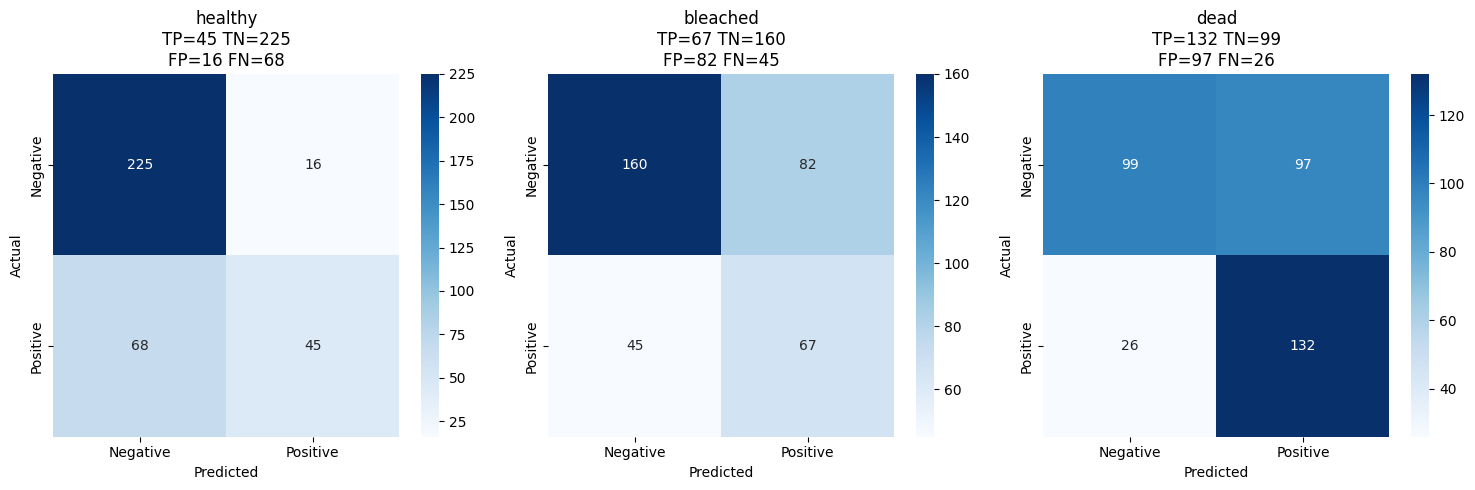

              precision    recall  f1-score   support

     healthy       0.74      0.40      0.52       113
    bleached       0.45      0.60      0.51       112
        dead       0.58      0.84      0.68       158

   micro avg       0.56      0.64      0.59       383
   macro avg       0.59      0.61      0.57       383
weighted avg       0.59      0.64      0.58       383
 samples avg       0.55      0.65      0.58       383



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report


y_true = test_generator.labels
y_pred_proba = model.predict(test_generator)  

# Apply class-specific thresholds
thresholds = {'healthy': 0.5, 'bleached': 0.3, 'dead': 0.4}
# Convert thresholds to array in class order [healthy, bleached, dead]
threshold_array = np.array(list(thresholds.values()))  
y_pred = (y_pred_proba > threshold_array).astype(int)

# 2. Generate confusion matrices for each class
classes = ["healthy", "bleached", "dead"]
mcm = multilabel_confusion_matrix(y_true, y_pred)

# 3. Plot confusion matrices
plt.figure(figsize=(15, 5))
for i, (matrix, class_name) in enumerate(zip(mcm, classes)):
    plt.subplot(1, 3, i+1)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{class_name}\nTP={matrix[1,1]} TN={matrix[0,0]}\nFP={matrix[0,1]} FN={matrix[1,0]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

# 4. Print classification report
print(classification_report(y_true, y_pred, target_names=classes))